## ReD plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def normalize_physics_props(case_params):
    """
    Normalize the physics properties in-place.
    """
    case_params["RE"] = (
        case_params["RE"] - 2822.248243559719
    ) / 3468.165537716764

def normalize_bc(case_params):
    """
    Normalize the boundary conditions in-place.
    """
    case_params['vel_top'] = (case_params['vel_top'] - 12.245551723507026) / 15.53312988836465

input_list = []
parm_list  = []
stable_state_diff = 0.0001

for i,re in enumerate([50, 400, 1000, 5000]): # , 3200
    pth = f'/home/data2/cenjianhuan/NewData/cavity/MIX_DATA/D_0.5_Re_{re}.csv'
    data = np.loadtxt(pth, delimiter=',', skiprows=9)
    print(data.shape)
    x = data[:, 0].reshape(128, 128)[::2,::2]
    y = data[:, 1].reshape(128, 128)[::2,::2]
    u = data[:, 2::3].reshape(128, 128, -1)[::2,::2]
    v = data[:, 3::3].reshape(128, 128, -1)[::2,::2]
    p = data[:, 4::3].reshape(128, 128, -1)[::2,::2]
    U = np.sqrt(u**2 + v**2)
    this_case_params = {'RE': re, 'density': 1.0, 'height': 0.5, 'vel_top': 1.0, 'width': 1.0}

    num_steps = U.shape[-1] - 1
    for i in range(num_steps):
        inp = np.stack((u[:,:,i], v[:,:,i], p[:,:,i]), axis=-1)
        out = np.stack((u[:,:,i+1], v[:,:,i+1], p[:,:,i+1]), axis=-1)
        # Check for convergence
        inp_magn = np.sqrt(inp[:,:,0] ** 2 + inp[:,:,1] ** 2 + inp[:,:,2] ** 2)
        out_magn = np.sqrt(out[:,:,0] ** 2 + out[:,:,1] ** 2 + out[:,:,2] ** 2)
        diff = np.abs(inp_magn - out_magn).mean()
        if diff < stable_state_diff and i / num_steps > 1 / 10:
            print(
                f"Converged at {i} out of {num_steps},"
                f" {this_case_params}"
            )
            break
    
    # Normalize the physics properties
    normalize_physics_props(this_case_params)
    normalize_bc(this_case_params)
    
    case_params_vec = []
    for k in ['RE', 'density', 'height', 'vel_top', 'width']:
        # print(k, this_case_params[k])
        case_params_vec.append(this_case_params[k])
    case_params = torch.tensor(case_params_vec).reshape(1, 1, 1, 5).repeat(1, 64, 64, 1)  #(p)
    parm_list.append(case_params)
    input_list.append(np.stack((u, v, p), axis=-1).transpose(2, 0, 1, 3))

# mask (1, 64, 64, 1)
mask = torch.ones(1, 64, 64, 1)
# grid (1, 64, 64, 2)
grid = torch.stack([torch.tensor(x).float(), torch.tensor(y).float()], dim=-1).unsqueeze(0)
# case_params (case, 1, 64, 64, 5)
case_params = torch.cat(parm_list, dim=0)
# input (case, T, 64, 64, 2)
inputs = torch.tensor(input_list)
print(inputs.shape, case_params.shape, grid.shape, mask.shape)

(16384, 3005)
Converged at 101 out of 1000, {'RE': 50, 'density': 1.0, 'height': 0.5, 'vel_top': 1.0, 'width': 1.0}
(16384, 3005)
Converged at 101 out of 1000, {'RE': 400, 'density': 1.0, 'height': 0.5, 'vel_top': 1.0, 'width': 1.0}
(16384, 3005)
Converged at 120 out of 1000, {'RE': 1000, 'density': 1.0, 'height': 0.5, 'vel_top': 1.0, 'width': 1.0}
(16384, 3005)
Converged at 301 out of 1000, {'RE': 5000, 'density': 1.0, 'height': 0.5, 'vel_top': 1.0, 'width': 1.0}
torch.Size([4, 1001, 64, 64, 3]) torch.Size([4, 64, 64, 5]) torch.Size([1, 64, 64, 2]) torch.Size([1, 64, 64, 1])


/tmp/ipykernel_2714029/3430353496.py:69: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552411/work/torch/csrc/utils/tensor_new.cpp:230.)
  inputs = torch.tensor(input_list)


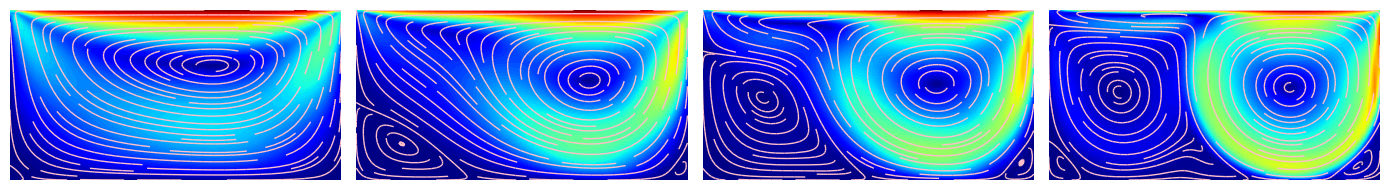

In [46]:
U_max = []
U_min = []
fig, axs = plt.subplots(1, 4, figsize=(14,2))
fig.set_tight_layout(True)
for i in range(4):
    U = torch.sqrt(inputs[i, :, :, :, 0] ** 2 + inputs[i, :, :, :, 1] ** 2).cpu().numpy()
    U_max.append(U.max())
    U_min.append(U.min())
    u = inputs[i, :, :, :, 0].cpu().numpy()
    v = inputs[i, :, :, :, 1].cpu().numpy()
    axs[i].axis("off")
    extent = [x.min(), x.max(), y.min(), y.max()]
    case_id = -1
    axs[i].contourf(x, y, U[case_id], 100, cmap='jet', extent=extent, vmin=U_min[i], vmax=U_max[i])
    axs[i].streamplot(x, y, u[case_id], v[case_id], color='pink', linewidth=1, arrowsize=0)
plt.show()

Model OFormer has 1368067 parameters
Load model from ./checkpoint/OFormer/cavity_ReD/OFormer_lr0.0006_bs16cavityReD-best.pt
start ploting...


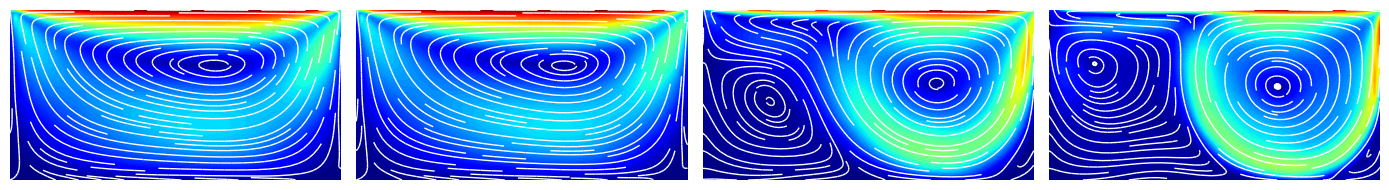

In [33]:
from utils import get_model, setup_seed
import yaml
import numpy as np
import os
import matplotlib.pyplot as plt
import torch

# 修改模型
model = 'OFormer'

config_file = f'./config/{model}/config_cavity_ReD_bc_re.yaml'
with open(config_file, 'r') as f:
    args = yaml.safe_load(f)
args['dataset']['multi_step_size'] = 1
args['dataset']['case_name'] = 'ReD'
setup_seed(args["seed"])

#init
device = torch.device("cpu") # "cuda:0" if torch.cuda.is_available() else 
saved_dir = os.path.join(args["saved_dir"], os.path.join(args["model_name"], args["flow_name"] + '_' + args['dataset']['case_name']))

fig_dir = os.path.join(args['output_dir'], 'fig')
fig_dir = os.path.join(fig_dir, os.path.join(args["model_name"],args["flow_name"] + '_' + args['dataset']['case_name']))
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

dataset_args = args["dataset"]

saved_model_name = (args["model_name"] + 
                    f"_lr{args['optimizer']['lr']}" +
                    f"_bs{args['dataloader']['train_batch_size']}" +
                    args["flow_name"] + 
                    dataset_args['case_name']
                    )

saved_path = os.path.join(saved_dir, saved_model_name)
min_ = torch.tensor([-0.7218633890151978, -0.7599146366119385, -12.665838241577148]) # .reshape(1, 1, 1, 3)
max_ = torch.tensor([ 0.9996230602264404,  0.45396965742111206, 18.963367462158203]) # .reshape(1, 1, 1, 3)
args["model"]["num_points"] = 64*64

#model
model = get_model(2, 5, args)
num_params = sum(p.numel() for p in model.parameters())
print(f"Model {args['model_name']} has {num_params} parameters")

#load checkpoint
checkpoint = torch.load(saved_path + "-best.pt")
print(f"Load model from {saved_path}-best.pt")
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

#test and plot
print('start ploting...')
results = []
max_iter = [101, 101, 120, 301] # [101, 101, 101, 101]
model.eval()
with torch.no_grad():
    inputs = inputs.float().to(device)
    case_params = case_params.float().to(device)
    grid = grid.float().to(device)
    mask = mask.float().to(device)
    for i in range(4):
        x = inputs[i][0].unsqueeze(0)
        params = case_params[i].unsqueeze(0)
        x = (x - min_) / (max_ - min_)
        # results.append(x)
        for j in range(max_iter[i]):
            pred = model(x, params, mask, grid)
            # if np.abs(np.sqrt(pred[0,0,0,0]**2 + pred[0,0,0,1]**2 + pred[0,0,0,2]**2) - np.sqrt(x[0,0,0,0]**2 + x[0,0,0,1]**2 + x[0,0,0,2]**2)) < 0.0001:
            #     print(f'converged at iter {j}')
            #     break
            x = pred.reshape(x.shape)
        results.append(pred.reshape(x.shape))

for i in range(4):
    # denormalize
    results[i] = results[i] * (max_ - min_) + min_
#plot
fig, axs = plt.subplots(1, 4, figsize=(14,2))
fig.set_tight_layout(True)
x = grid[0, :, :, 0].cpu().numpy()
y = grid[0, :, :, 1].cpu().numpy()
for i in range(4):
    U = np.sqrt(results[i][0,:,:,0].cpu().numpy()**2 + results[i][0,:,:,1].cpu().numpy()**2)
    u = results[i][0,:,:,0].cpu().numpy()
    v = results[i][0,:,:,1].cpu().numpy()
    axs[i].axis("off")
    extent = [x.min(), x.max(), y.min(), y.max()]
    im = axs[i].contourf(x, y, U, 100, cmap='jet', extent=extent, vmin=U_min[i], vmax=U_max[i])
    axs[i].streamplot(x, y, u, v, color='white', linewidth=1, arrowsize=0)
fig.savefig(os.path.join(fig_dir, 'cavity_ReD.png'))

## RE plots

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def normalize_physics_props(case_params):
    """
    Normalize the physics properties in-place.
    """
    case_params["RE"] = (
        case_params["RE"] - 2822.248243559719
    ) / 3468.165537716764

def normalize_bc(case_params):
    """
    Normalize the boundary conditions in-place.
    """
    case_params['vel_top'] = (case_params['vel_top'] - 12.245551723507026) / 15.53312988836465

input_list = []
parm_list  = []
stable_state_diff = 0.0001

for i,re in enumerate([1100, 3600, 6700, 9900]): # , 3200  
    pth = f'/home/data2/cenjianhuan/NewData/cavity/RE_DATA/Re_{re}.csv'
    data = np.loadtxt(pth, delimiter=',')
    print(data.shape)
    x = data[:, 0].reshape(128, 128)[::2,::2]
    y = data[:, 1].reshape(128, 128)[::2,::2]
    u = data[:, 2::3].reshape(128, 128, -1)[::2,::2]
    v = data[:, 3::3].reshape(128, 128, -1)[::2,::2]
    p = data[:, 4::3].reshape(128, 128, -1)[::2,::2]
    U = np.sqrt(u**2 + v**2)
    this_case_params = {'RE': re, 'density': 1.0, 'height': 1, 'vel_top': 1.0, 'width': 1.0}

    num_steps = U.shape[-1] - 1
    for i in range(num_steps):
        inp = np.stack((u[:,:,i], v[:,:,i], p[:,:,i]), axis=-1)
        out = np.stack((u[:,:,i+1], v[:,:,i+1], p[:,:,i+1]), axis=-1)
        # Check for convergence
        inp_magn = np.sqrt(inp[:,:,0] ** 2 + inp[:,:,1] ** 2 + inp[:,:,2] ** 2)
        out_magn = np.sqrt(out[:,:,0] ** 2 + out[:,:,1] ** 2 + out[:,:,2] ** 2)
        diff = np.abs(inp_magn - out_magn).mean()
        if diff < stable_state_diff and i / num_steps > 1 / 10:
            print(
                f"Converged at {i} out of {num_steps},"
                f" {this_case_params}"
            )
            break
    
    # Normalize the physics properties
    normalize_physics_props(this_case_params)
    normalize_bc(this_case_params)
    
    case_params_vec = []
    for k in ['RE', 'density', 'height', 'vel_top', 'width']:
        # print(k, this_case_params[k])
        case_params_vec.append(this_case_params[k])
    case_params = torch.tensor(case_params_vec).reshape(1, 1, 1, 5).repeat(1, 64, 64, 1)  #(p)
    parm_list.append(case_params)
    inputs = np.stack((u, v, p), axis=-1).transpose(2, 0, 1, 3)
    input_list.append(torch.tensor(inputs))

# mask (1, 64, 64, 1)
mask = torch.ones(1, 64, 64, 1)
# grid (1, 64, 64, 2)
grid = torch.stack([torch.tensor(x).float(), torch.tensor(y).float()], dim=-1).unsqueeze(0)
# case_params (case, 1, 64, 64, 5)
case_params = torch.cat(parm_list, dim=0)
# input (case, T, 64, 64, 2)
inputs = input_list
print(inputs[0].shape, case_params.shape, grid.shape, mask.shape)

In [ ]:
U_max = []
U_min = []
fig, axs = plt.subplots(1, 4, figsize=(14,4))
fig.set_tight_layout(True)
for i in range(4):
    U = torch.sqrt(inputs[i][ :, :, :, 0] ** 2 + inputs[i][:, :, :, 1] ** 2).cpu().numpy()
    U_max.append(U.max())
    U_min.append(U.min())
    u = inputs[i][:, :, :, 0].cpu().numpy()
    v = inputs[i][:, :, :, 1].cpu().numpy()
    x = grid[0, :, :, 0].cpu().numpy()
    y = grid[0, :, :, 1].cpu().numpy()
    axs[i].axis("off")
    extent = [x.min(), x.max(), y.min(), y.max()]
    case_id = -1
    axs[i].contourf(x, y, U[case_id], 500, cmap='jet', extent=extent, vmin=U_min[i], vmax=U_max[i])
    axs[i].streamplot(x, y, u[case_id], v[case_id], color='white', linewidth=1, arrowsize=0, broken_streamlines=True)
plt.show()

In [ ]:
from utils import get_model, setup_seed
import yaml
import numpy as np
import os
import matplotlib.pyplot as plt
import torch

# 修改模型
model = 'OFormer'

config_file = f'./config/{model}/config_cavity_ReD_bc_re.yaml'
with open(config_file, 'r') as f:
    args = yaml.safe_load(f)
args['dataset']['multi_step_size'] = 1
args['dataset']['case_name'] = 're'
setup_seed(args["seed"])

#init
device = torch.device("cpu") # "cuda:0" if torch.cuda.is_available() else 
saved_dir = os.path.join(args["saved_dir"], os.path.join(args["model_name"], args["flow_name"] + '_' + args['dataset']['case_name']))

fig_dir = os.path.join(args['output_dir'], 'fig')
fig_dir = os.path.join(fig_dir, os.path.join(args["model_name"],args["flow_name"] + '_' + args['dataset']['case_name']))
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

dataset_args = args["dataset"]

saved_model_name = (args["model_name"] + 
                    f"_lr{args['optimizer']['lr']}" +
                    f"_bs{args['dataloader']['train_batch_size']}" +
                    args["flow_name"] + 
                    dataset_args['case_name']
                    )

saved_path = os.path.join(saved_dir, saved_model_name)
min_ = torch.tensor([-0.42775022983551025, -0.7351908683776855, -4.729204177856445]) # .reshape(1, 1, 1, 3)
max_ = torch.tensor([ 0.9286808967590332,  0.40977877378463745,  4.623359680175781]) # .reshape(1, 1, 1, 3)
args["model"]["num_points"] = 64*64

#model
model = get_model(2, 5, args)
num_params = sum(p.numel() for p in model.parameters())
print(f"Model {args['model_name']} has {num_params} parameters")

#load checkpoint
checkpoint = torch.load(saved_path + "-best.pt")
print(f"Load model from {saved_path}-best.pt")
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

#test and plot
print('start ploting...')
results = []
max_iter = [267, 439, 895, 992] # [1001, 1001, 1001, 1001] # 
model.eval()
with torch.no_grad():
    inputs = inputs
    case_params = case_params.float().to(device)
    grid = grid.float().to(device)
    mask = mask.float().to(device)
    for i in range(4):
        x = inputs[i][0].unsqueeze(0).float().to(device)
        params = case_params[i].unsqueeze(0)
        x = (x - min_) / (max_ - min_)
        # results.append(x)
        for j in range(max_iter[i]):
            pred = model(x, params, mask, grid)
            # if np.abs(np.sqrt(pred[0,0,0,0]**2 + pred[0,0,0,1]**2 + pred[0,0,0,2]**2) - np.sqrt(x[0,0,0,0]**2 + x[0,0,0,1]**2 + x[0,0,0,2]**2)) < 0.0001:
            #     print(f'converged at iter {j}')
            #     break
            x = pred.reshape(x.shape)
        results.append(pred.reshape(x.shape))

for i in range(4):
    # denormalize
    results[i] = results[i] * (max_ - min_) + min_

#plot
fig, axs = plt.subplots(1, 4, figsize=(14,4))
fig.set_tight_layout(True)
x = grid[0, :, :, 0].cpu().numpy()
y = grid[0, :, :, 1].cpu().numpy()
for i in range(4):
    U = np.sqrt(results[i][0,:,:,0].cpu().numpy()**2 + results[i][0,:,:,1].cpu().numpy()**2)
    u = results[i][0,:,:,0].cpu().numpy()
    v = results[i][0,:,:,1].cpu().numpy()
    axs[i].axis("off")
    extent = [x.min(), x.max(), y.min(), y.max()]
    im = axs[i].contourf(x, y, U, 100, cmap='jet', extent=extent, vmin=U_min[i], vmax=U_max[i])
    axs[i].streamplot(x, y, u, v, color='white', linewidth=1, arrowsize=0)